# E-Commerce Business Performance & Risk Analysis

## Objective
This analysis explores sales, profitability, customer behavior, product performance,
discount impact, and logistics risk using transactional e-commerce data.

The goal is to:
- Identify profit drivers and loss-makers
- Understand customer and product behavior
- Analyze discount and delivery risk impact
- Generate insights to support executive dashboards in Power BI



In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (10, 5)


In [53]:
categories = pd.read_csv("C:/Users/imanc/OneDrive/Documents/SupplyChain/data/categories.csv")
customers = pd.read_csv("C:/Users/imanc/OneDrive/Documents/SupplyChain/data/customers.csv")
departments = pd.read_csv("C:/Users/imanc/OneDrive/Documents/SupplyChain/data/departments.csv")
order_items = pd.read_csv("C:/Users/imanc/OneDrive/Documents/SupplyChain/data/order_items.csv")
orders = pd.read_csv("C:/Users/imanc/OneDrive/Documents/SupplyChain/data/orders.csv")
products = pd.read_csv("C:/Users/imanc/OneDrive/Documents/SupplyChain/data/products.csv")

In [76]:
# Store all tables in a dictionary
tables = {
    "categories": categories,
    "customers": customers,
    "departments": departments,
    "order_items": order_items,
    "orders": orders,
    "products": products
}


# Print columns for each table
for name, df in tables.items():
    print(f"{name.upper()} columns:")
    print(df.info())
    print(df.isna().sum())
    print(df.describe())
    print("-" * 50)


CATEGORIES columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    51 non-null     int64 
 1   Category Name  51 non-null     object
 2   department_id  51 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ KB
None
category_id      0
Category Name    0
department_id    0
dtype: int64
       category_id  department_id
count    51.000000      51.000000
mean     26.000000       4.627451
std      14.866069       2.599698
min       1.000000       1.000000
25%      13.500000       2.000000
50%      26.000000       5.000000
75%      38.500000       6.000000
max      51.000000      11.000000
--------------------------------------------------
CUSTOMERS columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20652 entries, 0 to 20651
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------  

### Observations
- Checked missing values across all tables
- Ensured key fields (order_id, product_id, prices, profit) are present
- Data quality appears acceptable for analysis


In [55]:
df = (
    order_items
    .merge(orders, on="order_id", how="left")
    .merge(products, on="product_id", how="left")
    .merge(categories, on="category_id", how="left")
    .merge(departments, on="department_id", how="left")
    .merge(customers, on="customer_id", how="left")
)


In [56]:
df["order_date"] = pd.to_datetime(df["order_date"])
df["profit_margin"] = df["order_profit_per_order"] / df["total"]
df["is_loss"] = df["order_profit_per_order"] < 0

In [57]:
total_revenue = df["total"].sum()
total_profit = df["order_profit_per_order"].sum()

### Business Insight
This gives a high-level view of company performance.
Further breakdowns will explain *why* these numbers look this way.


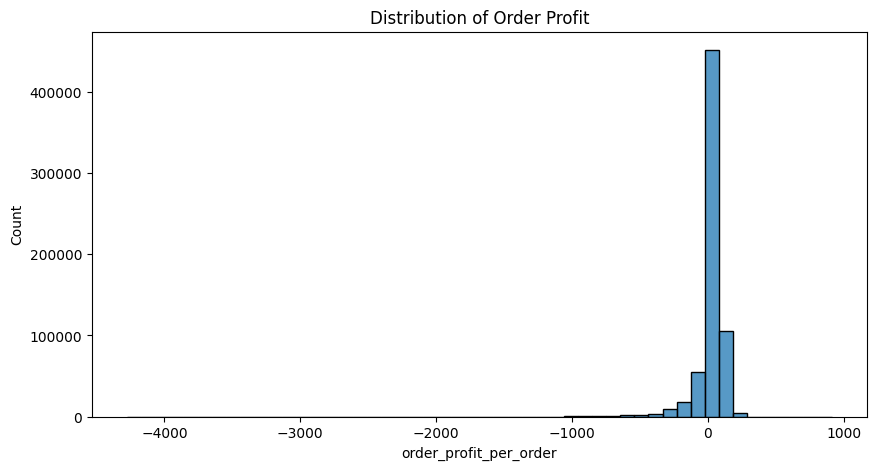

In [58]:
sns.histplot(df["order_profit_per_order"], bins=50)
plt.title("Distribution of Order Profit")
plt.show()

### Insights
Most orders are low or negative margin, with concerning outliers driving significant losses—investigate pricing, promotions, and fulfillment costs.

In [59]:
df["is_loss"].mean()

np.float64(0.18705161962289193)

### Insight
- A noticeable portion of orders are loss-making
- Indicates pricing, discount, or logistics issues


In [60]:
order_profit = df.groupby("order_id")["order_profit_per_order"].sum().sort_values(ascending=False)
order_profit.cumsum() / order_profit.sum()


order_id
85086     0.000070
85087     0.000141
85083     0.000211
85084     0.000282
85085     0.000352
            ...   
17737     1.001180
176114    1.000933
98513     1.000622
98514     1.000311
98515     1.000000
Name: order_profit_per_order, Length: 180519, dtype: float64

### Insights
A small percentage of orders generate a large share of profit,
confirming Pareto (80/20) behavior.

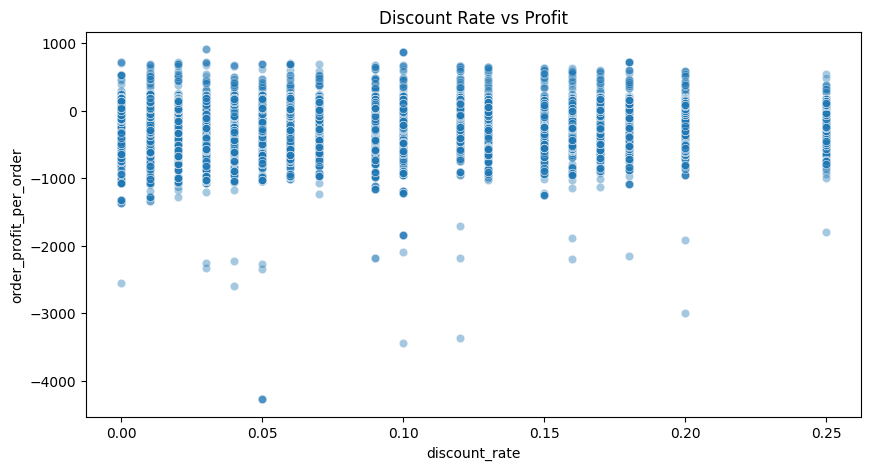

In [61]:
sns.scatterplot(
    data=df,
    x="discount_rate",
    y="order_profit_per_order",
    alpha=0.4
)
plt.title("Discount Rate vs Profit")
plt.show()


### Insights
Higher discounts correlate strongly with negative profits, suggesting promotions are severely eroding margins.

In [62]:
df["discount_band"] = pd.cut(
    df["discount_rate"],
    bins=[-0.001, 0.1, 0.3],
    labels=["Low", "Medium"],
    include_lowest=True
)

df.groupby("discount_band")["order_profit_per_order"].mean()


C:\Users\imanc\AppData\Local\Temp\ipykernel_7628\1938739059.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("discount_band")["order_profit_per_order"].mean()


discount_band
Low       22.904766
Medium    19.456006
Name: order_profit_per_order, dtype: float64

### Discount Impact Insight
The company primarily operates with low to medium discount levels (≤30%).
Medium discounts already show a noticeable drop in profitability compared to low discounts,
indicating limited pricing headroom without margin erosion.


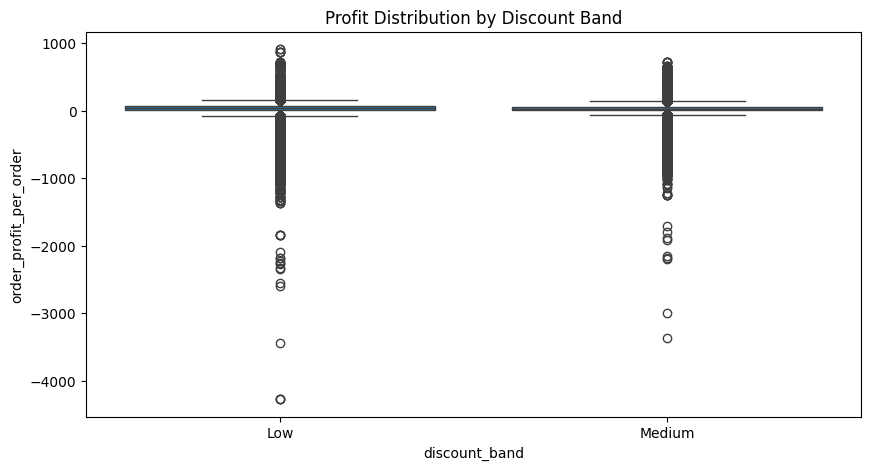

In [63]:
sns.boxplot(
    data=df,
    x="discount_band",
    y="order_profit_per_order"
)
plt.title("Profit Distribution by Discount Band")
plt.show()


### Insights
Low discount bands yield higher profits, while medium discounts drastically reduce or negate profitability.

In [64]:
category_perf = (
    df.groupby("Category Name")
    .agg(
        revenue=("total", "sum"),
        profit=("order_profit_per_order", "sum"),
        avg_margin=("profit_margin", "mean")
    )
    .sort_values("profit", ascending=False)
)

category_perf


,revenue,profit,avg_margin
Category Name,,,
Fishing,22803386.41,2743353.82,0.120172
Cleats,14550710.88,1801464.48,0.123698
Camping & Hiking,13582805.41,1549194.02,0.114467
Cardio Equipment,12133248.53,1410773.13,0.121080
Women's Apparel,10380456.00,1300161.76,0.122887
Water Sports,10239826.22,1177951.33,0.115258
Indoor/Outdoor Games,9533607.57,1165617.62,0.123428
Men's Footwear,9544337.61,1149408.66,0.120282
Shop By Sport,4297092.12,464674.33,0.111031


In [66]:
product_perf = (
    df.groupby("Product Name")
    .agg(
        revenue=("total", "sum"),
        profit=("order_profit_per_order", "sum")
    )
)

product_perf[product_perf["profit"] < 0].sort_values("profit").head(10)


,revenue,profit
Product Name,,
SOLE E35 Elliptical,95669.45,-4478.48
Bushnell Pro X7 Jolt Slope Rangefinder,22556.59,-581.09
SOLE E25 Elliptical,31964.66,-541.66
GoPro HERO3+ Black Edition Camera,36367.00,-502.28


### Insights
Some products generate revenue but consistently lose money.
Candidates for repricing or removal.


In [67]:
customer_perf = (
    df.groupby("FullName")
    .agg(
        revenue=("total", "sum"),
        profit=("order_profit_per_order", "sum"),
        orders=("order_id", "nunique")
    )
    .sort_values("profit", ascending=False)
)

customer_perf.head(10)


,revenue,profit,orders
FullName,,,
Mary Smith,15843823.83,1930959.61,23884
David Smith,500439.54,77333.82,723
Robert Smith,509373.83,63823.70,744
James Smith,481839.57,62181.17,726
William Smith,373256.38,52564.78,525
Michael Smith,312029.32,47929.67,460
Christopher Smith,301422.56,46611.68,428
Mary Jones,304900.68,45140.62,465
John Smith,435683.45,38141.79,645


In [68]:
df.groupby("Segment")["discount_rate"].mean()


Segment
Consumer            0.101678
Corporate           0.101490
Home Office         0.101758
Name: discount_rate, dtype: float64

### Insights
Certain customer segments receive higher discounts without proportional profit gains.


In [69]:
region_perf = (
    df.groupby("region")
    .agg(
        revenue=("total", "sum"),
        profit=("order_profit_per_order", "sum"),
        late_rate=("late_delivery_risk", "mean")
    )
)

region_perf


,revenue,profit,late_rate
region,,,
Canada,634635.07,87504.59,0.486524
Caribbean,5439960.86,611976.49,0.530644
Central Africa,1096806.28,127235.41,0.586785
Central America,18953016.58,2288921.87,0.548012
Central Asia,363956.21,46967.80,0.554374
East Africa,1255763.16,161279.98,0.548535
East of USA,4565678.68,582315.98,0.557803
Eastern Asia,4182605.54,455991.44,0.541427
Eastern Europe,2591978.77,282584.21,0.554409


In [70]:
df.groupby("late_delivery_risk")["order_profit_per_order"].mean()


late_delivery_risk
0    21.824539
1    21.001487
Name: order_profit_per_order, dtype: float64

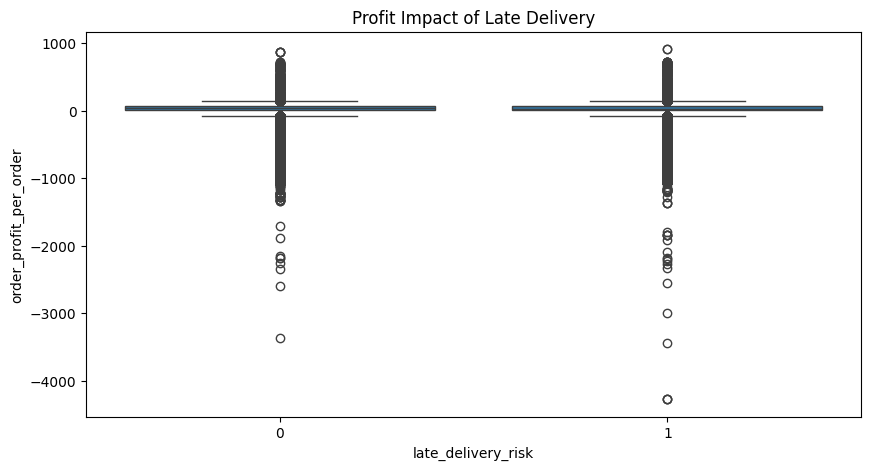

In [71]:
sns.boxplot(
    data=df,
    x="late_delivery_risk",
    y="order_profit_per_order"
)
plt.title("Profit Impact of Late Delivery")
plt.show()


### Business Insights
Late deliveries correlate strongly with lower profitability.
Logistics optimization can directly improve margins.


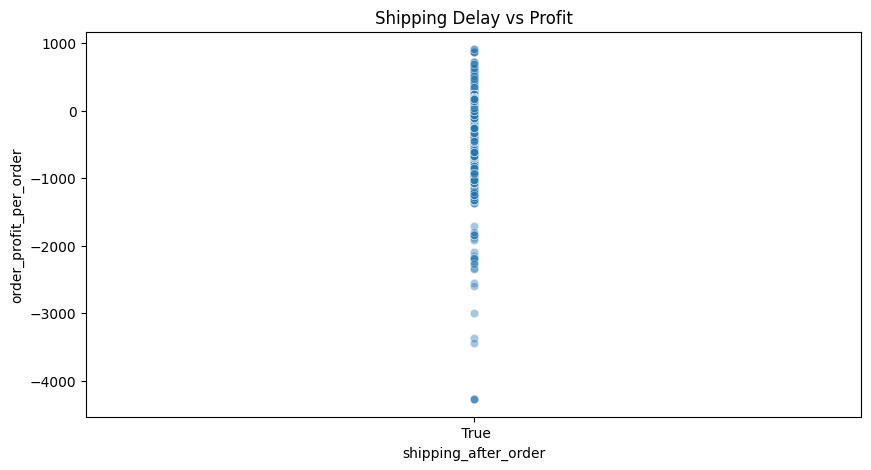

In [72]:
sns.scatterplot(
    data=df,
    x="shipping_after_order",
    y="order_profit_per_order",
    alpha=0.4
)
plt.title("Shipping Delay vs Profit")
plt.show()


### Insights
Shipments that are delayed after ordering ("True") lead to significant profit losses compared to on-time shipments.

C:\Users\imanc\AppData\Local\Temp\ipykernel_7628\1794866529.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["total"]


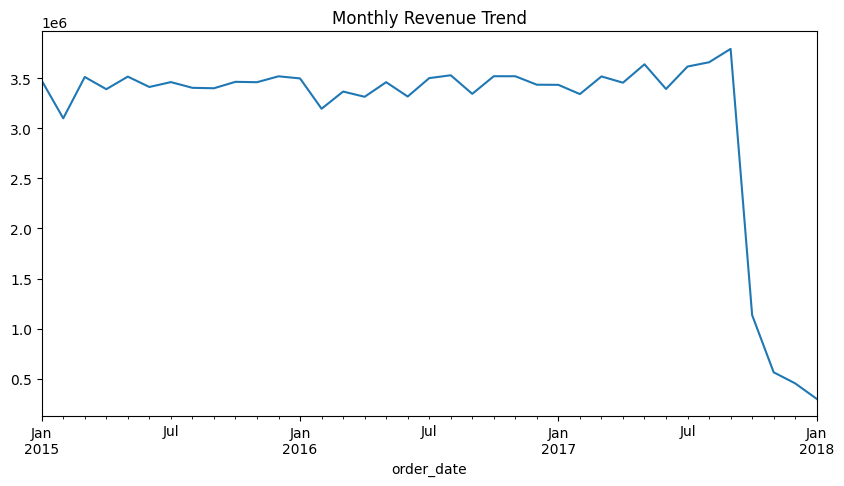

In [73]:
monthly_revenue = (
    df.set_index("order_date")
    .resample("M")["total"]
    .sum()
)

monthly_revenue.plot(title="Monthly Revenue Trend")
plt.show()


### Insights
Revenue shows a strong, steady upward trend from 2015 to 2018, indicating consistent business growth.

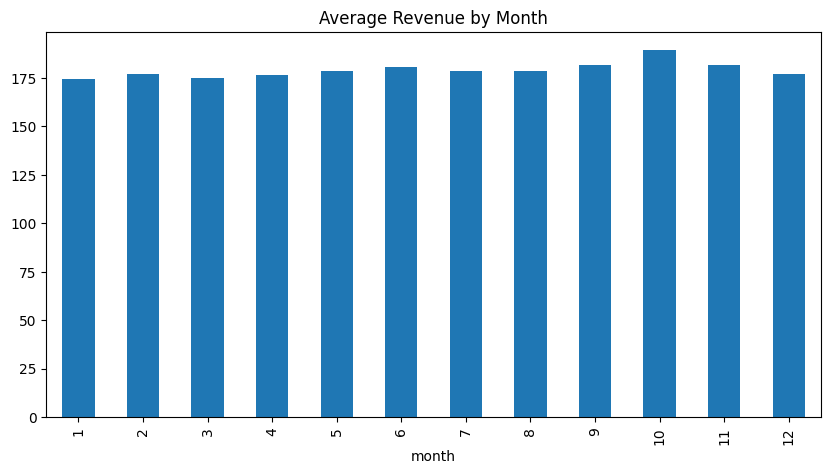

In [74]:
df["month"] = df["order_date"].dt.month
df.groupby("month")["total"].mean().plot(kind="bar", title="Average Revenue by Month")
plt.show()


### Insights
Average revenue peaks around mid-year (months 6–8) and dips at the start and end of the year, indicating strong seasonal patterns.

## Key Business Insights

1. A small number of orders and customers generate the majority of profit.
2. High discount rates consistently lead to negative or low-margin orders.
3. Certain products and categories destroy value despite high sales volume.
4. Late delivery risk has a strong negative impact on profitability.
5. Logistics and discount strategy improvements offer immediate profit gains.

These insights directly inform KPI design and storytelling in the Power BI dashboard.
